<center><font size = "10"> Week 13 - Simplification<center>
<center><font size = "8">Tutorial 02: Point Neurons Network<center>

<font size='3'><font color='blue'> This tutorial provides an overview of how to use the Integarte-And-Fire [(IF)](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html) neuron model implemented in Neuron to build neural network with point neurons.

## Load useful packages and external files

In [1]:
from neuron import h
import matplotlib.pyplot as plt
import numpy as np

# Load external files & initialize
h.load_file("stdrun.hoc");
soma = h.Section() # dummy section so h._ref_t works

# 1. Create point neuron network 

## 1.1 Define number of cells and E/I rate

In [2]:
Nneur = 16 # number of neurons in network
pExc = 0.65 # probability of cell being excitatory

## 1.2 Create cell population

<font size='3'>[IntFire4](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IntFire4)

In [3]:
rng = np.random.default_rng()

# create cell population with fixed parameters
cells = []
for i in range(0,Nneur):
    if4 = h.IntFire4()
    if4.taum = 8 # membrane time constant
    if4.taui1 = 8 # inhibitory current time constant 1
    if4.taui2 = 10 # inhibitory current time constant 2
    if4.taue = 5 # excitatory current time constant
    typ = 'Exc' if rng.uniform() < pExc else 'Inh' # sample type
    cells.append({ 'GID': i, 'cell': if4, 'type': typ, 'conns': [], 'spikes': h.Vector(), 'V': None, 'I': None, 'E': None })

NExc = len([x for x in cells if x['type'] == 'Exc'])
NInh = Nneur - NExc
print("Have {} Exc cells and {} Inh cells in network".format(NExc,NInh))

Have 13 Exc cells and 3 Inh cells in network


## 1.3 Define cell connectivity

In [4]:
import itertools

# connect cells with random weights (all-to-all but self)
for src_cell,tgt_cell in itertools.product(cells,cells):
    src = src_cell['cell']
    tgt = tgt_cell['cell']
    if src == tgt:
        dummy = h.NetCon(src, None) # dummy netcon to record events
        dummy.record(src_cell['spikes']) # record spikes
    else:
        w = 0.8 * rng.uniform() # random uniform in [0:0.8)
        w = w if src_cell['type'] == 'Exc' else -w # weight positive (Exc) or negative (Inh)
        nc = h.NetCon(src, tgt) # new netcon between src and tgt
        nc.weight[0] = w # set weight
        nc.delay = rng.integers(5,15) # set delay
        src_cell['conns'].append(nc) # save netcon in source cell

In [5]:
print("Have {} connections in total: E-E = {}; E-I = {}; I-E = {}; I-I = {}".format(
    Nneur*Nneur-Nneur,NExc*NExc-NExc,NExc*NInh,NExc*NInh,NInh*NInh-NInh))

Have 240 connections in total: E-E = 156; E-I = 39; I-E = 39; I-I = 6


## 1.4 Define stimulation 

In [6]:
# Setup external stimulation (otherwise no activity at all!)
stim = h.NetStim()
stim.start = 5
stim.number = 500
stim.interval = 10

stimcell = None
for cell in cells:
    if cell['type'] == 'Exc':
        stimcell = cell['cell']
        break
    
stim_nc = h.NetCon(stim, stimcell) # connect to first Exc cell
stim_nc.weight[0] = 0.8
stimvec = h.Vector()
stim_nc.record(stimvec)

0.0

## 1.5 Record voltage from cells

In [7]:
# Setup reporting
tvec = h.Vector()
tvec.record(h._ref_t)

for cell in cells:
    cell['V'] = h.Vector()

## 1.6 Run simulation

In [8]:
# Run simulation (may take a while!)

# initialize
h.stdinit()
h.finitialize(-65)

# store initial value after init
for cell in cells:
    cell['V'].append(cell['cell'].M())

tstop = 100 # final time
nstep = np.int(np.ceil(tstop / h.dt)) # number of time steps
for i in range(0,nstep):
    h.fadvance() # advance time step
    for cell in cells:
        cell['V'].append(cell['cell'].M()) # record M function

In [9]:
# Collect all spikes
spikes = []
for cell in cells:
    spk = [(t,cell['GID']) for t in cell['spikes']]
    spikes += spk
spikes = np.array(spikes)

print("Have {} spikes in total".format(len(spikes)))

Have 31302 spikes in total


## 1.7 Plots

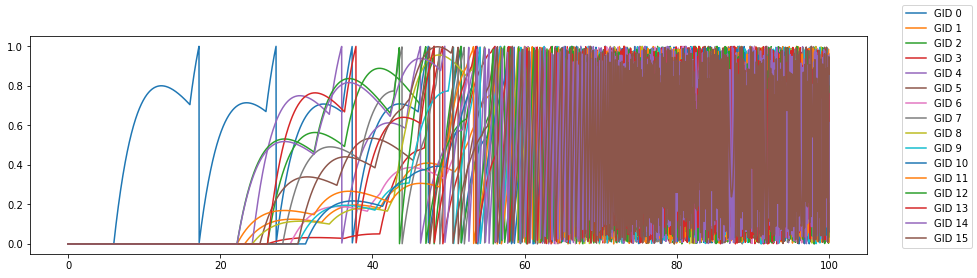

In [10]:
# plot voltage traces
fig, ax = plt.subplots(figsize=(15,4))
for cell in cells:
    ax.plot(tvec,cell['V'],label='GID {}'.format(cell['GID']))
fig.legend()
None

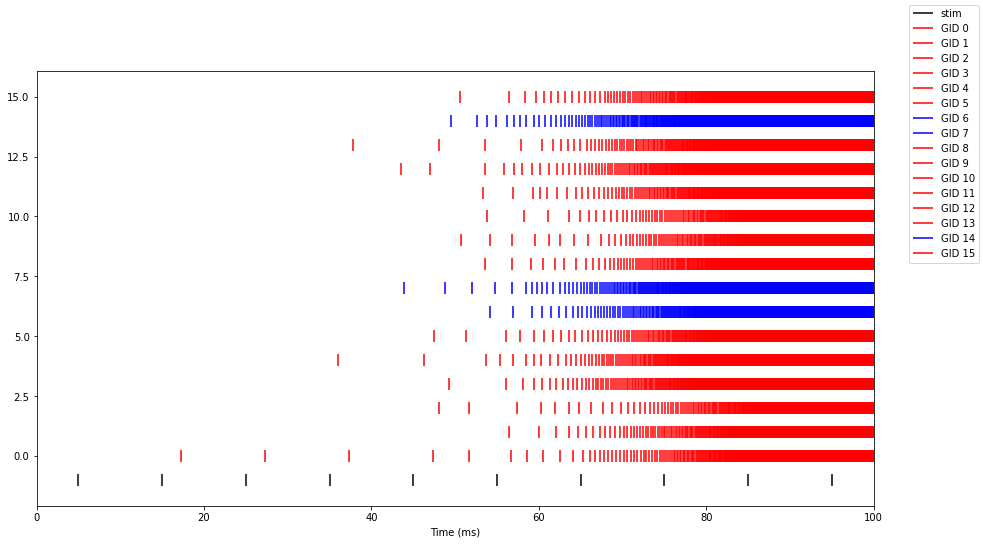

In [11]:
# plot spike raster
fig, ax = plt.subplots(figsize=(15,8))
ax.vlines(stimvec, ymin=-0.75 - 0.5, ymax=-0.25 - 0.5, color='black', label='stim')
for cell in cells:
    c = 'red' if cell['type'] == 'Exc' else 'blue'
    gid = cell['GID']
    ymin = gid + 0.25 - 0.5
    ymax = gid + 0.75 - 0.5
    if len(cell['spikes']) > 0:
        ax.vlines(cell['spikes'], ymin=ymin, ymax=ymax, color=c, label='GID {}'.format(gid))
ax.set_xlim((0,tstop))
ax.set_xlabel('Time (ms)')
fig.legend()
None